In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data_process import master

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
master_df = master()
print(master_df.columns)
print('-' * 50)
print(master_df.shape)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'delivery_against_estimated',
       'order_purchase_yea

### New Customer Yearly Basis
New Customer vs Existing

In [3]:
# Extract useful columns only to save cost
cols = ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
        'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng',
        'geolocation_city', 'geolocation_state', 'order_id', 'order_status',
        'order_purchase_timestamp', 'order_approved_at',
        'order_delivered_carrier_date', 'order_delivered_customer_date',
        'order_estimated_delivery_date', 'order_item_id', 'product_id',
        'price', 'freight_value',
        'payment_sequential', 'payment_type', 'payment_installments',
        'payment_value', 
        'product_description_lenght', 'product_photos_qty', 'product_weight_g',
        'product_category_name_english', 'delivery_against_estimated',
        'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
        'order_purchase_dayofweek', 'order_purchase_hr']
customers = master_df[cols].copy(deep = True)
del master_df

In [4]:
# Check Memory Usage
import tracemalloc

# starting the monitoring 
tracemalloc.start()

print(tracemalloc.get_traced_memory())

(469, 10650)


In [5]:
customer_min_purchase = customers.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
customer_min_purchase.columns = ['customer_unique_id','min_purchase_date']
print(customer_min_purchase.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95828 entries, 0 to 95827
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  95828 non-null  object        
 1   min_purchase_date   93139 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB
None


In [6]:
# merge the first purchase date with customer df
customers_intel = pd.merge(customers, customer_min_purchase, on = 'customer_unique_id', how = 'inner')
customers_intel['usertype'] = 'New'
customers_intel.loc[customers_intel['order_purchase_timestamp'] > customers_intel['min_purchase_date'], 'usertype'] = 'Regular Customers'

# sum the monthly revenue in different customer groups (new vs existing)
customers_usertype_revenue = customers_intel.groupby(['order_purchase_timestamp', 'usertype'])['payment_value'].agg(['sum']).reset_index()

print(customers_usertype_revenue.head())

  order_purchase_timestamp usertype       sum
0      2016-09-04 21:15:19      New  17709.90
1      2016-09-05 00:15:34      New   7731.18
2      2016-10-02 22:07:52      New   5685.68
3      2016-10-03 09:44:50      New   2045.70
4      2016-10-03 16:56:50      New  10515.21


In [7]:
customers_usertype_revenue['usertype'][1]

'New'

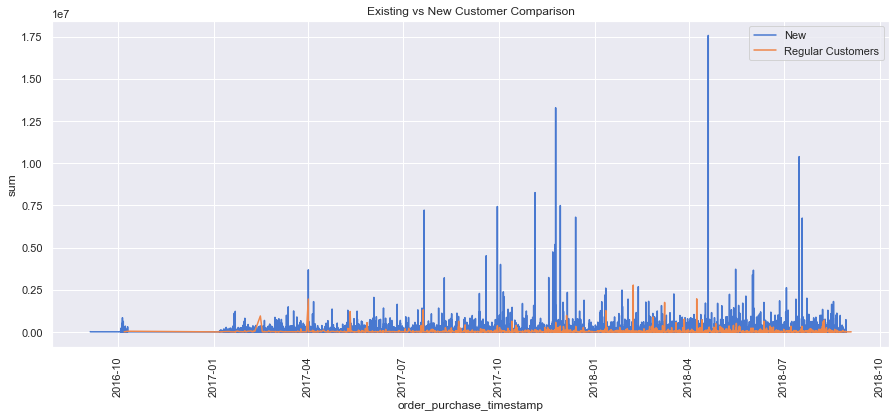

In [13]:
# Line chart to show 
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='order_purchase_timestamp', y='sum', data=customers_usertype_revenue.query("usertype == New"), label='New')
ax = sns.lineplot(x='order_purchase_timestamp', y='sum', data=customers_usertype_revenue.query("usertype == 'Regular Customers'"), label='Regular Customers')
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

#### Yearly New Customer Ratio

In [10]:
#create a dataframe that shows new user ratio 
df_user_ratio = customers_intel.query("usertype == 'New'").groupby(['order_purchase_timestamp'])['customer_unique_id'].nunique()/customers_intel.query("usertype == 'Regular Customers'").groupby(['order_purchase_timestamp'])['customer_unique_id'].nunique()
df_user_ratio = df_user_ratio.reset_index()

#dropping nan values that resulted from first and last month
df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ['order_purchase_timestamp','NewCusRatio']

# show the data frame
df_user_ratio.head(20)

,order_purchase_timestamp,NewCusRatio
2987,2017-03-04 15:23:16,1.0
35154,2017-11-24 13:30:59,1.0
36054,2017-11-25 14:04:11,1.0
58700,2018-03-08 23:18:44,1.0
62928,2018-03-27 19:07:09,1.0
71172,2018-05-03 17:26:34,1.0
72288,2018-05-07 22:14:31,1.0
74889,2018-05-16 20:57:48,1.0
75054,2018-05-17 16:38:18,1.0
89716,2018-08-02 12:05:57,1.0


/var/folders/c3/z8gl7_754n15kcrx5rz7k0840000gn/T/ipykernel_80256/3190068189.py:41: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)


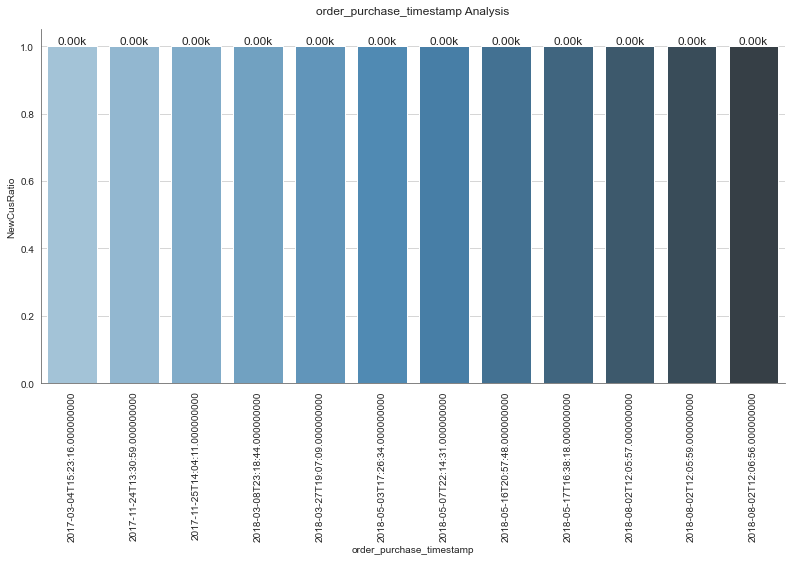

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
# bar_plot(x='order_purchase_timestamp', y='NewCusRatio', df=df_user_ratio, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

#### Customer Lifetime Value
Customer Value = Average Order Value * Purchase Frequency

In [42]:
customers_intel.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id', 'price',
       'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g',
       'product_category_name_english', 'delivery_against_estimated',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hr', 'min_purchase_date',
       'usertype'],
      dtype='object')

In [46]:
customer_group = customers_intel.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda date:(date.max() - date.min()).days,
    'order_id': lambda order: order.count(),
    'payment_value': lambda price: price.sum()}
)

customer_group.head()

,order_purchase_timestamp,order_id,payment_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,66,9365.40
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,144,3915.36
0000f46a3911fa3c0805444483337064,0.0,117,10087.74
0000f6ccb0745a6a4b88665a16c9f078,0.0,32,1395.84
0004aac84e0df4da2b147fca70cf8255,0.0,133,26186.37


In [52]:
customer_group.columns = ['num_days', 'num_transactions', 'spent_money']
customer_group['avg_order_value'] = customer_group['spent_money'] / customer_group['num_transactions']

In [53]:
purchase_frequency = sum(customer_group['num_transactions']) / customers_intel.shape[0]
# Repeat rate
repeat_rate = customer_group[customer_group['num_transactions'] > 1].shape[0] / customer_group.shape[0]
# Churn Rate
churn_rate = 1 - repeat_rate


0.9756324822519885


In [ ]:
print(f'Purchase Frequency: {purchase_frequency}')
print(f'Repeat Rate: {repeat_rate}')
print(f'Churn Rate: {churn_rate}')

In [ ]:
# Calculate Profit Margin
## let's assume business has approximate 5% profit on the total sales
customer_group['profit_margin'] = customer_group['spent_money'] * 0.05
customer_group['CLV'] = (customer_group['avg_order_value'] * customer_group['profit_margin'])
customer_group.head()

#### RFM 

* Recency
* Frequency
* Monetary Value

Segmentation of customer in online retail includes RFM analysis and clustering

In [14]:
def rfm(df):
    df_recency = df.groupby(by = 'customer_unique_id')['order_purchase_timestamp'].max().reset_index()
    df_recency.columns = ['customer_unique_id', 'Last Purchase Date']
    recent_date = df_recency['Last Purchase Date'].max()
    
    df_recency['Recency'] = df_recency['Last Purchase Date'].apply(lambda x: (recent_date - x).days)
    
    frequency_df = df.drop_duplicates().groupby(by = ['customer_unique_id'], as_index = False)['order_purchase_timestamp'].count().reset_index()
    frequency_df.columns = ['customer_unique_id','Frequency']
    

    monetary_df = df.groupby(by = ['customer_unique_id'], as_index = False)['payment_value'].sum().reset_index()
    monetary_df.columns = ['customer_unique_id', 'monetary']
    
    rf_df = df_recency.merge(frequency_df, on = 'customer_unique_id', how = 'inner')
    rfm_df = rf_df.merge(monetary_df, on = 'customer_unique_id', how = 'inner').drop(columns = 'Last Purchase Date')
    
    return rfm_df

customer_rfm = rfm(customers)

                 customer_unique_id  Last Purchase Date
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42


### K-means and DBSCAN

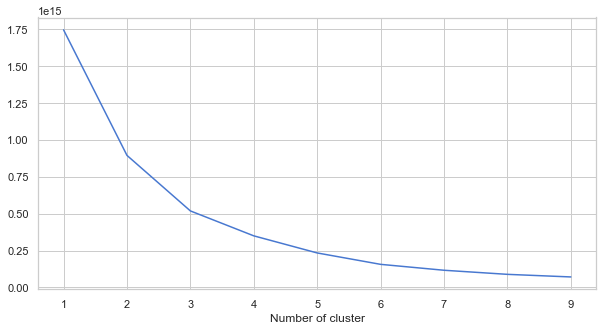

In [34]:
from sklearn.cluster import KMeans,DBSCAN

sse={}
customer_rfm = customer_rfm.fillna(0)
df_kmeans = customer_rfm[['Recency','Frequency','monetary']]
customer_id = customer_rfm.customer_unique_id
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_kmeans)
    df_kmeans["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


We can see that the "elbow" on the graph above (where the interia becomes more linear) is at K = 3. We can then fit our K-means algorithms one more time and plot the different clusters assigned to the data.

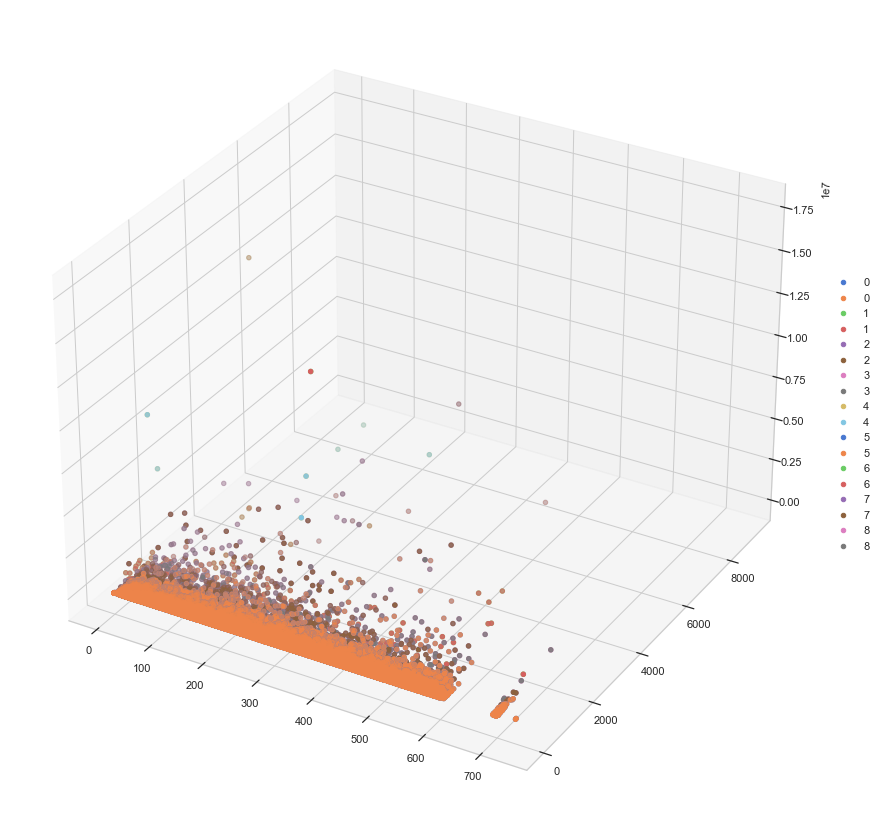

In [35]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_kmeans)

fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(projection='3d')
for grp_name, grp_idx in df_kmeans.groupby('clusters').groups.items():
    y = df_kmeans.iloc[grp_idx, 1]
    x = df_kmeans.iloc[grp_idx, 0]
    z = df_kmeans.iloc[grp_idx, 2]
    ax.scatter(x, y, z, label=grp_name)  # this way you can control color/marker/size of each group freely
    ax.scatter(*df_kmeans.iloc[grp_idx, [0, 1, 2]].T.values,
               label=grp_name)  # if you want to do everything in one line, lol

ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
plt.show()

In [37]:
clustering = DBSCAN(eps=12.5, min_samples=4).fit(df_kmeans)
DBSCAN_dataset = df_kmeans.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_

DBSCAN_dataset.Cluster.value_counts().to_frame()

In [40]:
DBSCAN_dataset.head()

,Recency,Frequency,monetary,clusters,Cluster
0,115.0,51,9365.40,0,716
1,118.0,60,3915.36,0,575
2,541.0,78,10087.74,0,-1
3,325.0,28,1395.84,0,-1
4,292.0,102,26186.37,0,-1


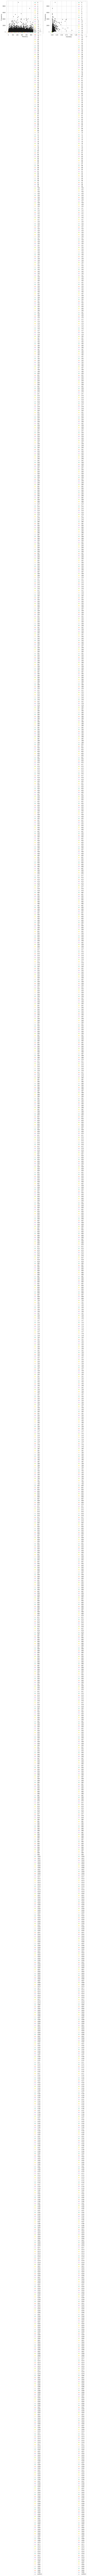

In [41]:
outliers = DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Recency', 'Frequency',

                data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1],

                hue='Cluster', ax=axes[0], palette='Set2', legend='full', s=200)

sns.scatterplot('monetary', 'Frequency',

                data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1],

                hue='Cluster', palette='Set2', ax=axes[1], legend='full', s=200)

axes[0].scatter(outliers['Recency'], outliers['Frequency'], s=10, label='outliers', c="k")

axes[1].scatter(outliers['monetary'], outliers['Frequency'], s=10, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='12')
plt.setp(axes[1].get_legend().get_texts(), fontsize='12')

plt.show()

Customer Lifetime Value (CLV)